# RIAA Filter
This investigates different implementations of the [RIAA equalization](https://en.wikipedia.org/wiki/RIAA_equalization)

It investigates a forum post that came up with a set of RIAA parameters from reverse-engineering an analog design. It then traces these parameters to the source-code of `sox`, a
[Cross-platform Audio-Editing software](https://en.wikipedia.org/wiki/SoX)

[Official sox homepage](http://sox.sourceforge.net/)

We finally try to derive the correct RIAA parameters.

In [1]:
from scipy.signal import lfilter, tf2zpk, zpk2tf, freqz, group_delay, freqs_zpk 
import matplotlib.pyplot as plt
import numpy as np
from math import e, pi, sin, cos
%matplotlib inline

In [2]:
def plot_response(w, h, title = 'Frequency response', f0 = None, log = False, lin = False) :
    fig = plt.figure ()
    ax1 = fig.add_subplot (111)
    if log :
        ax1.set_xscale ('log')
    plt.title (title)
    xlabel = 'Freq [rad/sample]'
    if f0 is not None :
        w = np.array (w) * f0 / (2 * pi)
        xlabel = 'Freq (Hz)'
        if f0 == 1.0 :
            xlabel = '$\\Omega$'
    if lin :
        plt.plot (w, abs (h), 'b')
        plt.ylabel ('Amplitude (lin.)', color = 'b')
    else :
        plt.plot (w, 20 * np.log10 (abs (h)), 'b')
        plt.ylabel ('Amplitude (dB)', color = 'b')
    plt.xlabel (xlabel)
    plt.grid (which = 'both')

    ax2 = ax1.twinx ()
    angles = np.unwrap (np.angle (h))
    plt.plot (w, angles, 'g')
    plt.ylabel ('Angle (rad)', color = 'g')
    plt.axis ('tight')
    plt.show ()

In [3]:
def plot_delay(w, d, title = "Group delay", f0 = None, log = False) :
    fig = plt.figure ()
    ax1 = fig.add_subplot (111)
    if log :
        ax1.set_xscale ('log')
    plt.title (title)
    xlabel = 'Freq [rad/sample]'
    if f0 is not None :
        w = np.array (w) * f0 / (2 * pi)
        xlabel = 'Freq (Hz)'
        if f0 == 1.0 :
            xlabel = '$\\Omega$'
    plt.plot (w, d, 'b')
    plt.ylabel ('Delay', color = 'b')
    plt.xlabel (xlabel)

    plt.grid ()
    plt.axis ('tight')
    plt.show ()

In [4]:
def pole_zero_plot (poles, zeros, limit = 1e6) :
    poles = np.array (poles)
    zeros = np.array (zeros)
    m1 = m2 = 1
    if len (poles) :
        m1 = max (abs (poles))
    if len (zeros) :
        m2 = max (abs (zeros))
    m  = max (m1, m2) + 1
    if m > limit :
        m = limit
    plt.plot(np.real(zeros), np.imag(zeros), 'ob')
    plt.plot(np.real(poles), np.imag(poles), 'xr')
    plt.legend(['Zeros', 'Poles'], loc=2)
    plt.title('Pole / Zero Plot')
    plt.ylabel('Real')
    plt.xlabel('Imag')
    plt.grid()
    plt.xlim (-m, m)
    plt.ylim (-m, m)
    plt.gca ().set_aspect ('equal', adjustable='box')
    plt.show()


In [5]:
def update_conjugate_complex (numbers) :
    """ Modify numbers in-place to add conjugate complex numbers"""
    n2 = [k.conjugate () for k in numbers if k.imag]
    numbers.extend (n2)

### Audacity RIAA parameters
The Software Audacity contains a RIAA curve specified as a list of frequency/gain pairs.
RIAA Parameters (curve) from source-code of
[Audacity](https://www.audacityteam.org/) in the file `presets/EQDefaultCurves.xml`:

In [6]:
# Audacity RIAA curve
audacity_riaa = \
[ (20.00,    19.274)
, (25.00,    18.954)
, (31.00,    18.516)
, (40.00,    17.792)
, (50.00,    16.946)
, (63.00,    15.852)
, (80.00,    14.506)
, (100.00,   13.088)
, (125.00,   11.563)
, (160.00,    9.809)
, (200.00,    8.219)
, (250.00,    6.677)
, (315.00,    5.179)
, (400.00,    3.784)
, (500.00,    2.648)
, (630.00,    1.642)
, (800.00,    0.751)
, (1000.00,   0.000)
, (1250.00,  -0.744)
, (1600.00,  -1.643)
, (2000.00,  -2.589)
, (2500.00,  -3.700)
, (3150.00,  -5.038)
, (4000.00,  -6.605)
, (5000.00,  -8.210)
, (6300.00,  -9.980)
, (8000.00,  -11.894)
, (10000.00, -13.734)
, (12500.00, -15.609)
, (16000.00, -17.708)
, (20000.00, -19.620)
, (25000.00, -21.542)
, (48000.00, -27.187)
]

def compare_to_audacity (a, b, fs) :
    aud_frq = np.array (list (k for k, v in audacity_riaa if k <= fs / 2)) / fs * 2 * pi
    aud_w, aud_h = freqz (b, a, aud_frq)
    aud_db = 20 * np.log10 (abs (aud_h))
    for n, (f, db) in enumerate (audacity_riaa) :
        if f > fs / 2 :
            break
        print ("%s %s %s %s" % (f, aud_db [n], db, abs (db - aud_db [n])))

[Forum Post](https://www.musicdsp.org/en/latest/Filters/122-digital-riaa-equalization-filter-coefficients.html)
Claims the following:

    The s-domain transfer function is

    R3(1+R1*C1*s)(1+R2*C2*s)/(R1(1+R2*C2*s) + R2(1+R1*C1*s) +
    R3(1+R1*C1*s)(1+R2*C2*s))

    where
    `R1 = 883.3k`
    `R2 = 75k`
    `R3 = 604`
    `C1 = 3.6n`
    `C2 = 1n`
    This is based on the reference circuit found in http://www.hagtech.com/pdf/riaa.pdf
    The coefficients of the digital transfer function `b(z^-1)/a(z^-1)`
    in descending powers of z, are:

Note: This is the *inverse* RIAA (for recording not for playback)
and one of 44.1 kHz or 48 kHz is wrong (they're identical).
Also note that the analog circuit that was used as a basis of
reverse engineering claims that in the original recording
equipment there was a pole at 3.18µs (about 50kHz). This has been
disputed in 2009 in an
[article by Keith Howard in "stereophile"](https://www.stereophile.com/content/cut-and-thrust-riaa-lp-equalization-page-2)

The analog circuit realizing this pole for playback by Jim Hagerman in linked here:
[Link to analog circuit](http://www.hagtech.com/pdf/riaa.pdf)

Parameters from the forum post for recording:

#### 44.1kHz
```
b = [ 0.02675918611906  -0.04592084787595   0.01921229297239]
a = [ 1.00000000000000  -0.73845850035973  -0.17951755477430]
error +/- 0.25dB
```
#### 48kHz
```
b = [  0.02675918611906  -0.04592084787595   0.01921229297239]
a = [  1.00000000000000  -0.73845850035973  -0.17951755477430]
error +/- 0.15dB
```
#### 88.2kHz
```
b = [  0.04872204977233  -0.09076930609195   0.04202280710877]
a = [ 1.00000000000000  -0.85197860443215  -0.10921171201431]
error +/- 0.01dB
```
#### 96kHz
```
b = [ 0.05265477122714  -0.09864197097385   0.04596474352090  ]
a = [  1.00000000000000  -0.85835597216218  -0.10600020417219 ]
error +/- 0.006dB
```

Later post in same forum thread:

    FYI, here are working filter coefficients for biquad implementation
    of RIAA EQ Reproduction filters:

An the paramters, now with *different* sets for 44.1kHz and 48kHz:

#### 44.1kHz:
```
a = [ 1.0000000000 -1.7007240000  0.7029381524 ]
b = [ 1.0000000000 -0.7218922000 -0.1860520545 ]
error ~0.23dB
```
#### 48kHz:
```
a = [ 1.0000000000 -1.7327655000  0.7345534436 ]
b = [ 1.0000000000 -0.7555521000 -0.1646257113 ]
error ~0.14dB
```
#### 88.2kHz:
```
a = [ 1.0000000000 -1.8554648000  0.8559721393 ]
b = [ 1.0000000000 -0.8479577000 -0.1127631993 ]
error 0.008dB
```
#### 96kHz:
```
a = [ 1.0000000000 -1.8666083000  0.8670382873 ]
b = [ 1.0000000000 -0.8535331000 -0.1104595113 ]
error ~0.006dB
```
```
#### NOTES in Forum:
All these given filter coefficients produces a bit gained filter
(~+12.5dB or so) so, if you like to adjust the 1 kHz = 0dB, it can
be done quite accurately by finding linear difference using software
like Tobybear's FilterExplorer. Enter coefficients into
FilterExplorer, by moving mouse cursor over the plotted magnitude
curve in magnitude plot window, find/point the ~1kHz position and
then check the magnitude value (value inside the brackets) found in
info field. Use this value as divider for b coefficients.

#### Notes (by me):
It looks like the original analog circuit that was reverse-engineered
here has a pole at around 50kHz. To make such a high frequency pole
work the system must have a sampling rate of > 100kHz. So for all these
lower sampling rates the pole will be aliased (!) to a lower frequency.

In the following we check these parameters and print the zeros and
poles for this configuration.

In [7]:
# Coefficients from the forum post.
# Note that either the 44.1 or the 48 kHz value is bogus
# These are the *recording* values not the playback values
riaa = \
{   '44.1' :
    dict
        ( b = [0.02675918611906, -0.04592084787595,  0.01921229297239]
        , a = [1.00000000000000, -0.73845850035973, -0.17951755477430]
        )
,   '48.0' :
    dict
        ( b = [0.02675918611906, -0.04592084787595,  0.01921229297239]
        , a = [1.00000000000000, -0.73845850035973, -0.17951755477430]
        )
,   '88.2' :
    dict
        ( b = [0.04872204977233, -0.09076930609195,  0.04202280710877]
        , a = [1.00000000000000, -0.85197860443215, -0.10921171201431]
        )
,   '96.0' :
    dict
        ( b = [0.05265477122714, -0.09864197097385,  0.04596474352090]
        , a = [1.00000000000000, -0.85835597216218, -0.10600020417219]
        )
}
for k in riaa :
    d = riaa [k]
    d ['w'], d ['h'] = freqz (d ['b'], d ['a'])
    d ['wg'], d ['gd'] = group_delay ((d ['b'], d ['a']))
    z, p, g = tf2zpk (d ['b'], d ['a'])
    print ("zeros:", z, "poles:", p, "gain:", g)

zeros: [0.9931716 0.7229063] poles: [ 0.93123263 -0.19277413] gain: 0.02675918611906
zeros: [0.9931716 0.7229063] poles: [ 0.93123263 -0.19277413] gain: 0.02675918611906
zeros: [1.00356989 0.85943272] poles: [ 0.96513548 -0.11315687] gain: 0.04872204977233
zeros: [1.00328287 0.87008907] poles: [ 0.96787451 -0.10951854] gain: 0.05265477122714


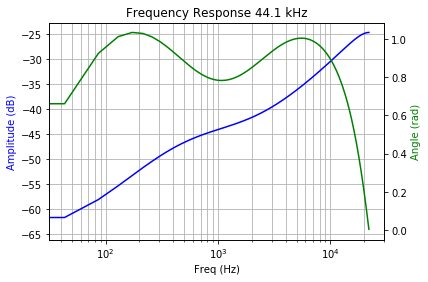

In [8]:
plot_response (riaa ['44.1']['w'], riaa ['44.1']['h'], 'Frequency Response 44.1 kHz', 44100, log = True)

In the following we have the parameters for *playback* from the forum post.
Note that when displaying the poles at the end we have

In [9]:
# Later in same forum post, these are the playback values
riaa = \
{   '44.1' :
    dict
        ( a = [ 1.0000000000, -1.7007240000,  0.7029381524 ]
        , b = [ 1.0000000000, -0.7218922000, -0.1860520545 ]
        )
,   '48.0' :
    dict
        ( a = [ 1.0000000000, -1.7327655000,  0.7345534436 ]
        , b = [ 1.0000000000, -0.7555521000, -0.1646257113 ]
        )
,   '88.2' :
    dict
        ( a = [ 1.0000000000, -1.8554648000,  0.8559721393 ]
        , b = [ 1.0000000000, -0.8479577000, -0.1127631993 ]
        )
,   '96.0' :
    dict
        ( a = [ 1.0000000000, -1.8666083000,  0.8670382873 ]
        , b = [ 1.0000000000, -0.8535331000, -0.1104595113 ]
        )
}
for k in riaa :
    d = riaa [k]
    d ['w'], d ['h'] = freqz (d ['b'], d ['a'])
    d ['wg'], d ['gd'] = group_delay ((d ['b'], d ['a']))
    d ['zero'], d ['pole'], d ['gain'] = tf2zpk (d ['b'], d ['a'])
    print ("zeros:", d ["zero"], "poles:", d ["pole"], "gain:", d ["gain"])


zeros: [ 0.923382  -0.2014898] poles: [0.9924091 0.7083149] gain: 1.0
zeros: [ 0.932159  -0.1766069] poles: [0.993133  0.7396325] gain: 1.0
zeros: [ 0.9648312 -0.1168735] poles: [0.9964002 0.8590646] gain: 1.0
zeros: [ 0.9676817 -0.1141486] poles: [0.9966946 0.8699137] gain: 1.0


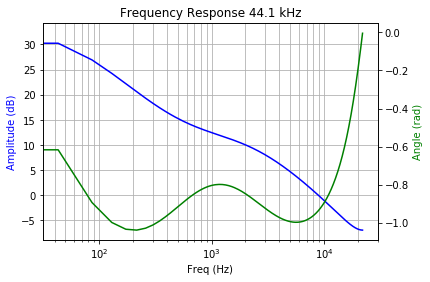

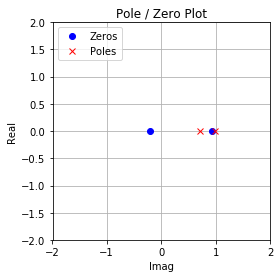

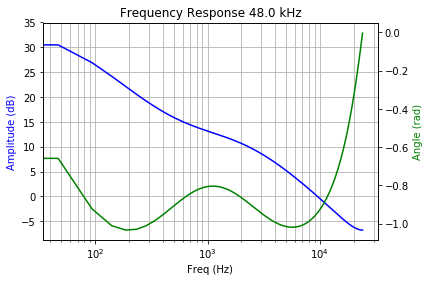

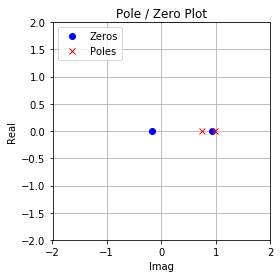

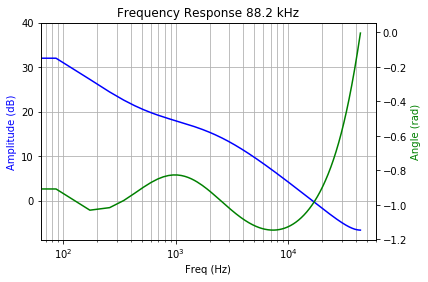

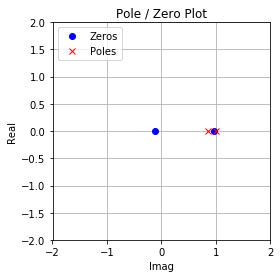

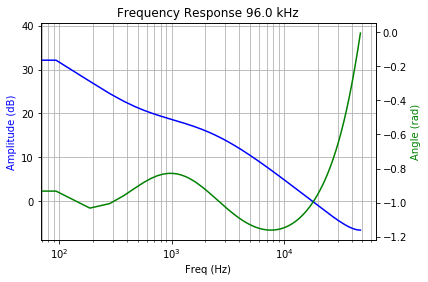

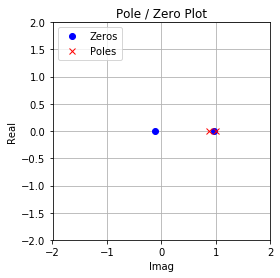

In [10]:
for k in riaa :
    d = riaa [k]
    plot_response (d ['w'], d ['h'], 'Frequency Response %s kHz' % k, f0 = 1000 * float (k), log=1)
    pole_zero_plot (d ['pole'], d ['zero'])
    #plot_delay (d ['wg'], d ['gd'], title = 'Group delay %s kHz' % k, f0 = 1000 * float (k), log=1)

## Source Code from `sox`
[RIAA equalization:](https://en.wikipedia.org/wiki/RIAA_equalization)
Coefficients taken from sox source-code in file `biquads.c`, this
has different polynomials for different sampling rates.

Note that the python-code below with comment
starting "Check that RIAA params..." checks that the a/b
parameters match with the parameters from the forum post
above. So it seems that the sox parameters are derived
from that forum post or some other source that has its
origing there.

We are normalizing the paramters so that the gain @1kHz
is 0dB as specified in the RIAA spec (or at least in what
Wikipedia has about the spec). As you can seen in the plots
the different curves for the different sampling frequencies
do not match.

Digital Gain: 0.23806122326320717 Gain @1kHz: 1.0


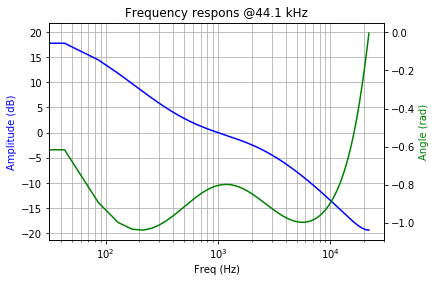

a: [ 1.         -1.700724    0.70293815] b: [ 0.23806122 -0.17185454 -0.04429178]
zeros: [-0.2014898, 0.923382] poles: [0.7083149, 0.9924091]
20.0 19.347428340096894 19.274 0.0734283400968927
25.0 19.060550829069843 18.954 0.10655082906984248
31.0 18.665240167100748 18.516 0.14924016710074994
40.0 18.002063254519758 17.792 0.21006325451975627
50.0 17.21554691421523 16.946 0.2695469142152298
63.0 16.18275300812978 15.852 0.33075300812977915
80.0 14.891630790897487 14.506 0.385630790897487
100.0 13.511360758274705 13.088 0.4233607582747059
125.0 12.006394759022779 11.563 0.4433947590227785
160.0 10.254703882955564 9.809 0.4457038829555646
200.0 8.646728533014095 8.219 0.4277285330140952
250.0 7.0658340639258155 6.677 0.3888340639258159
315.0 5.5075332819945455 5.179 0.32853328199454523
400.0 4.0318797503708055 3.784 0.24787975037080567
500.0 2.812765172397904 2.648 0.164765172397904
630.0 1.726504316286491 1.642 0.08450431628649113
800.0 0.7754827957781278 0.751 0.02448279577812784
1000.

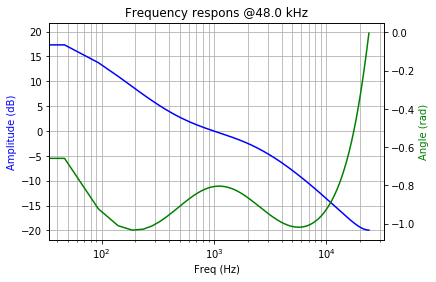

a: [ 1.         -1.7327655   0.73455344] b: [ 0.21973782 -0.16602337 -0.0361745 ]
zeros: [-0.1766069, 0.932159] poles: [0.7396325, 0.993133]
20.0 19.253608013783893 19.274 0.020391986216107938
25.0 18.959101832408493 18.954 0.005101832408492157
31.0 18.554146881302 18.516 0.03814688130200139
40.0 17.876834798006982 17.792 0.08483479800698035
50.0 17.076460198036813 16.946 0.1304601980368112
63.0 16.02950205936009 15.852 0.17750205936009067
80.0 14.725958276082743 14.506 0.21995827608274254
100.0 13.337712335981458 13.088 0.24971233598145837
125.0 11.829329906023487 11.563 0.2663299060234863
160.0 10.080032894860942 9.809 0.2710328948609426
200.0 8.48049252058479 8.219 0.26149252058479
250.0 6.914596790658286 6.677 0.23759679065828632
315.0 5.378972441729589 5.179 0.19997244172958872
400.0 3.9333986446205755 3.784 0.14939864462057573
500.0 2.7457007111304668 2.648 0.09770071113046663
630.0 1.6905758788856016 1.642 0.048575878885601664
800.0 0.7641849080208268 0.751 0.013184908020826835


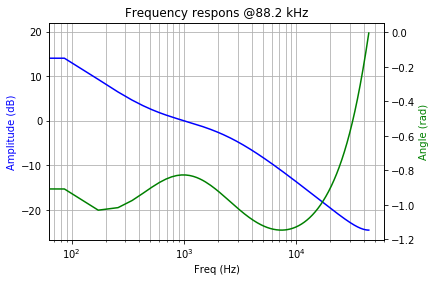

a: [ 1.         -1.8554648   0.85597214] b: [ 0.12671064 -0.10744526 -0.0142883 ]
zeros: [-0.1168735, 0.9648312] poles: [0.8590646, 0.9964002]
20.0 19.21011684696552 19.274 0.06388315303448167
25.0 18.895866513517184 18.954 0.058133486482816465
31.0 18.466091659671914 18.516 0.04990834032808422
40.0 17.752653789678064 17.792 0.03934621032193775
50.0 16.917076429797298 16.946 0.02892357020270353
63.0 15.834175595605494 15.852 0.017824404394506388
80.0 14.498691298189271 14.506 0.007308701810728735
100.0 13.088773654982695 13.088 0.0007736549826962147
125.0 11.568521789758371 11.563 0.005521789758370588
160.0 9.818663549060037 9.809 0.009663549060038079
200.0 8.23064697479873 8.219 0.011646974798731335
250.0 6.688128439336227 6.677 0.011128439336227203
315.0 5.188841577683591 5.179 0.009841577683590508
400.0 3.7912022029387153 3.784 0.007202202938715541
500.0 2.652423954497599 2.648 0.004423954497598803
630.0 1.6439399180364083 1.642 0.0019399180364083612
800.0 0.7518574116144118 0.751 0

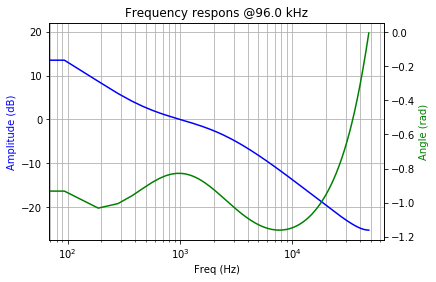

a: [ 1.         -1.8666083   0.86703829] b: [ 0.11714782 -0.09998954 -0.01294009]
zeros: [-0.1141486, 0.9676817] poles: [0.8699137, 0.9966946]
20.0 19.20916199997946 19.274 0.06483800002053997
25.0 18.89453487361686 18.954 0.05946512638314161
31.0 18.464289087998523 18.516 0.05171091200147515
40.0 17.75017136276942 17.792 0.04182863723058006
50.0 16.91393832963321 16.946 0.032061670366790196
63.0 15.830376095489678 15.852 0.02162390451032259
80.0 14.494313604814788 14.506 0.011686395185211751
100.0 13.084014143516228 13.088 0.003985856483771144
125.0 11.563567939235869 11.563 0.0005679392358679536
160.0 9.813734594291663 9.809 0.004734594291663896
200.0 8.22597042128274 8.219 0.006970421282741057
250.0 6.683929949935326 6.677 0.006929949935326363
315.0 5.185365127477396 5.179 0.0063651274773954825
400.0 3.7886569936079266 3.784 0.004656993607926818
500.0 2.650806828703272 2.648 0.0028068287032718686
630.0 1.6431805867208735 1.642 0.001180586720873622
800.0 0.7516932392305429 0.751 0.00

In [12]:
# Values from source-code of sox
sox_riaa = {}
sox_riaa ['44.1'] = dict \
    ( zero = [-0.2014898, 0.9233820]
    , pole = [ 0.7083149, 0.9924091]
    )
sox_riaa ['48.0'] = dict \
    ( zero = [-0.1766069, 0.9321590]
    , pole = [ 0.7396325, 0.9931330]
    )
sox_riaa ['88.2'] = dict \
    ( zero = [-0.1168735, 0.9648312]
    , pole = [ 0.8590646, 0.9964002]
    )
sox_riaa ['96.0'] = dict \
    ( zero = [-0.1141486, 0.9676817]
    , pole = [ 0.8699137, 0.9966946]
    )

# Check that RIAA params from forum are identical with sox params
for k in riaa :
    for zp in 'zero', 'pole' :
        for n1, n2 in zip (sorted (sox_riaa [k][zp]), sorted (riaa [k][zp])) :
            #print (n1, n2, n1 - n2)
            assert abs (n1 - n2) < 5e-10

(b, a) = zpk2tf (sox_riaa ['44.1']['zero'], sox_riaa ['44.1']['pole'], 1.0)
w, h = freqz (b, a)
wg, gd = group_delay ((b, a))
#plot_response (w, h, f0=44100, log = True)

# Normalize to 0dB for 1kHz
digital_gain = 1.0
for rk in sox_riaa :
    sr = sox_riaa [rk]
    fs = float (rk) * 1000.0
    z1kHz = 1000.0 / fs * 2 * pi
    for k in range (2) :
        (sr ['nb'], sr ['na']) = zpk2tf (sr ['zero'], sr ['pole'], digital_gain)
        w, h = freqz (sr ['nb'], sr ['na'], [z1kHz])
        #print (w, h, abs (h))
        digital_gain = abs (digital_gain / abs (h [0]))
        #print ("digital gain:", digital_gain)
    print ("Digital Gain:", digital_gain, "Gain @1kHz:", abs (h [0]))
    w, h = freqz (sr ['nb'], sr ['na'])
    plot_response (w, h, f0=fs, log = True, title = 'Frequency respons @%s kHz' % rk)
    print ("a:", sr ['na'], 'b:', sr ['nb'])
    print ("zeros:", sr ['zero'], "poles:", sr ['pole'])
    compare_to_audacity (sr ['na'], sr ['nb'], fs)

### Compute From S-Plane Filter Parameters taken from Wikipedia

In [ ]:
# Parameters from wikipedia
# For now we're only using the riaa parameter set.
# Note that the others are not really tested and the 'flat' set is definitely wrong
riaa = dict (szero = [318e-6], spole = [3180e-6, 75e-6], name = 'riaa')
bbc  = dict (szero = [318e-6], spole = [3180e-6, 50e-6], name = 'bbc')
flat = dict (szero = [319e-6], spole = [3180e-6], name = 'flat')
iec  = dict (szero = [318e-6], spole = [3180e-6, 75e-6, 7950e-6], name = 'iec')

def PZ (T, fs = 44100) :
    return e ** (-1.0 / (T * fs))

s1kHz = 1.0 / (2 * pi * 1000.)
analog_gain = 1.0

for fs in (44100., 48000., 88200., 96000.) :
    for filter in [riaa] :
        print ("Filter: %s, Sampling Frequency: %d" % (filter ['name'], fs))
        # Analog gain = 0dB @ 1kHz
        w, h = freqs_zpk (filter ['szero'], filter ['spole'], analog_gain, [s1kHz])
        #print (w, h, abs (h))
        analog_gain = abs (analog_gain / abs (h [0]))
        #print ("analog gain:", analog_gain)
        w, h = freqs_zpk (filter ['szero'], filter ['spole'], analog_gain, [s1kHz])
        #print ("Gain @1kHz:", abs (h [0]))
        # Plot response of analog filter
        #w, h = freqs_zpk (filter ['szero'], filter ['spole'], analog_gain)
        #plot_response (w, h, title='Frequency %s' % filter ['name'], log=True)

        filter ['zero'] = []
        filter ['pole'] = []
        for z in filter ['szero'] :
            pz = PZ (z, fs)
            filter ['zero'].append (pz)
        for p in filter ['spole'] :
            pz = PZ (p, fs)
            filter ['pole'].append (pz)
        print ('zeros:', filter ['zero'], 'poles:', filter ['pole'])

        # Digital gain = 0dB @ 1kHz
        digital_gain = 1.0
        z1kHz = 1000.0 / fs * 2 * pi
        for k in range (4) :
            (filter ['b'], filter ['a']) = zpk2tf (filter ['zero'], filter ['pole'], digital_gain)
            w, h = freqz (filter ['b'], filter ['a'], [z1kHz])
            #print (w, h, abs (h))
            digital_gain = abs (digital_gain / abs (h [0]))
            #print ("digital gain:", digital_gain)
        print ("Digital Gain:", digital_gain, "Gain @1kHz:", abs (h [0]))
        filter ['gain'] = digital_gain

        d = filter
        d ['w'], d ['h'] = freqz (d ['b'], d ['a'])
        d ['wg'], d ['gd'] = group_delay ((d ['b'], d ['a']))
        print ("zeros:", filter ['zero'], "poles:", filter ['pole'], "gain:", filter ['gain'])
        print ('a:', d ['a'], 'b:', d ['b'])
        pole_zero_plot (filter ['pole'], filter ['zero'])
        plot_response (d ['w'], d ['h'], title = "Frequency response %d" % fs, f0 = fs, log=1)
        compare_to_audacity (d ['a'], d ['b'], fs)
        print ()

In [ ]:
d = riaa
print ("a:", d ['a'], "b:", d['b'])
plot_response (d ['w'], d ['h'], f0 = 44100, log = True, title = 'FRQ response @44.1 kHz')
plot_delay (d ['wg'], d ['gd'], f0 = 44100, log = True, title = 'Group delay @44.1 kHz')